# 手撕Transformer
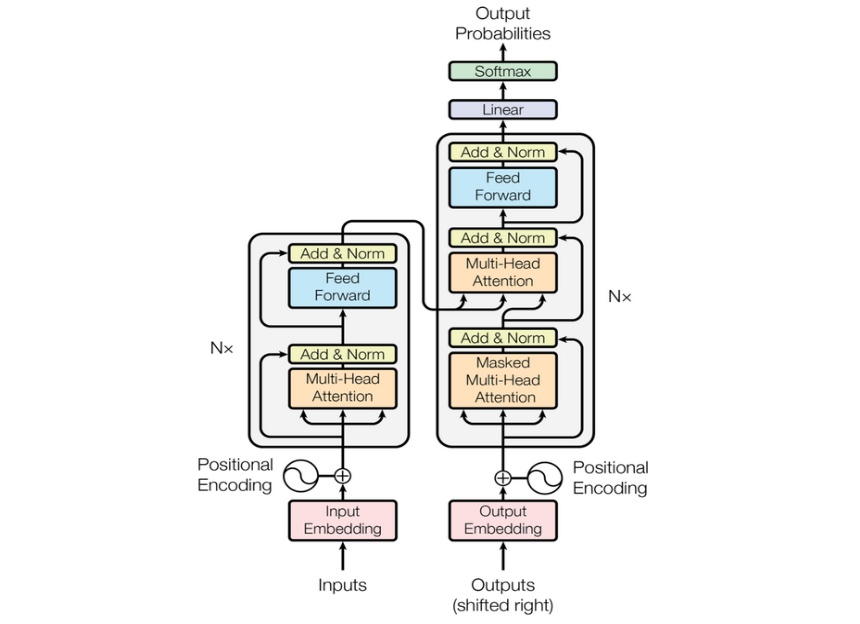

## 一、文本嵌入层
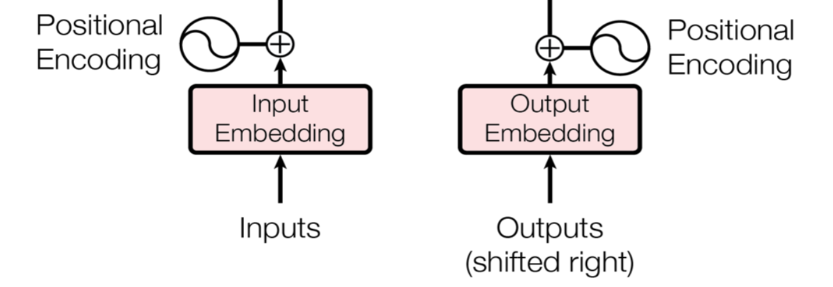
- **文本嵌入层的作用**

    - 无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示, 希望在这样的高维空间捕捉词汇间的关系

- **文本嵌入层代码分析**

In [1]:
# 导入必备的工具包
import torch
 
# 预定义的网络层torch.nn, 工具开发者已经帮助我们开发好的一些常用层, 
# 比如，卷积层, lstm层, embedding层等, 不需要我们再重新造轮子.
import torch.nn as nn
 
# 数学计算工具包
import math
 
# torch中变量封装函数Variable.
from torch.autograd import Variable
 
# 定义Embeddings类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层, 他们共享参数.
# 该类继承nn.Module, 这样就有标准层的一些功能, 这里我们也可以理解为一种模式, 我们自己实现的所有层都会这样去写.
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """类的初始化函数, 有两个参数, d_model: 指词嵌入的维度, vocab: 指词表的大小."""
        # 接着就是使用super的方式指明继承nn.Module的初始化函数, 我们自己实现的所有层都会这样去写.
        super(Embeddings, self).__init__()
        # 之后就是调用nn中的预定义层Embedding, 获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
        # 最后就是将d_model传入类中
        self.d_model = d_model
 
    def forward(self, x):
        """可以将其理解为该层的前向传播逻辑，所有层中都会有此函数
           当传给该类的实例化对象参数时, 自动调用该类函数
           参数x: 因为Embedding层是首层, 所以代表输入给模型的文本通过词汇映射后的张量"""
 
        # 将x传给self.lut并与根号下self.d_model相乘作为结果返回
 
        # 让 embeddings vector 在增加 之后的 postion encoing 之前相对大一些的操作，
        # 主要是为了让position encoding 相对的小，这样会让原来的 embedding vector 中的信息在和 position encoding 的信息相加时不至于丢失掉
        # 让 embeddings vector 相对大一些
        return self.lut(x) * math.sqrt(self.d_model)

/home/garen-lee/miniconda3/envs/uniad/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- **nn.Embedding演示**

In [2]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 1.2151, -0.2204,  1.6162],
         [-0.0243,  0.3307,  0.5208],
         [ 0.6202, -0.5879,  1.3350],
         [-0.4999, -2.3847,  0.0195]],

        [[ 0.6202, -0.5879,  1.3350],
         [-1.3564,  0.0601,  0.1682],
         [-0.0243,  0.3307,  0.5208],
         [ 1.2787,  0.4427,  0.8227]]], grad_fn=<EmbeddingBackward0>)

In [3]:
embedding = nn.Embedding(10, 3, padding_idx=2)
input = torch.LongTensor([[0,2,0,5]])
embedding(input)

tensor([[[-0.1326, -0.8415,  0.5813],
         [ 0.0000,  0.0000,  0.0000],
         [-0.1326, -0.8415,  0.5813],
         [ 1.1679, -0.5190, -0.4313]]], grad_fn=<EmbeddingBackward0>)

- **实例化参数**

In [4]:
# 词嵌入维度是512
d_model = 512
# 词表大小是1000
vocab = 1000

- **输入参数**

In [5]:
# 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))

- **调用与输出效果**

In [6]:
emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:", embr)
print(embr.shape)

embr: tensor([[[-32.7393,   3.0649,   8.7108,  ..., -42.1194,   2.4426,  31.8148],
         [ 32.3184,  24.1450,  10.9417,  ...,  25.7377,   1.0313,  13.9621],
         [ 33.4031,  16.5290,  -9.3316,  ..., -34.3460,  23.5138,   6.6676],
         [ 15.7550,  11.7889,  12.4468,  ..., -18.2665,  33.4889,  14.4125]],

        [[ -8.5730,  36.1309,  16.1838,  ...,  -7.4920, -41.7363,  11.3053],
         [-29.8006, -25.2407,   0.0933,  ...,  32.6949,   7.4500,  47.7094],
         [  2.1305,  -5.5537,  25.1537,  ...,   4.7739,  16.0176,  15.3828],
         [-22.1473, -18.1297, -20.8395,  ...,   3.5713, -24.7577, -21.1084]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


## 二、位置编码
位置编码(Positional Encoding)是[Transformer](https://gitcode.com/gh_mirrors/tr/transformer/overview?utm_source=highlight_word_gitcode&word=transformer&isLogin=1)模型中的一个重要组成部分，用于在序列数据中引入位置信息。由于Transformer模型本身不具备处理序列顺序的能力（因为它完全基于自注意力机制，没有递归或卷积结构），位置编码的引入是的模型能够利用序列的顺序信息。

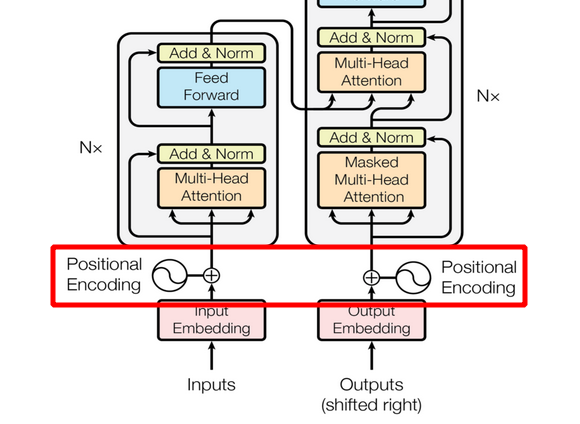

**位置编码的原理**
位置编码通过输入嵌入向量中添加一个与位置相关的向量来实现。具体来说，对于每一个位置($pos$)和每个维度($i$)，位置编码向量($PE\left(pos,2i\right)$)和($PE\left(pos,2i+1\right)$)分别由以下公式计算


$$
\begin{aligned}
PE\left(pos,2i\right)&=sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)\\
PE\left(pos,2i+1\right)&=cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{aligned}
$$
其中$d_{model}$是模型的维度，$pos$是位置，$i$是维度索引

**代码解释**
以下是`PositionalEncoder`

In [7]:
import torch
import torch.nn as nn
import math
# 定义位置编码器类, 我们同样把它看做一个层, 因此会继承nn.Module    
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_seq_len=5000):
        """位置编码器类的初始化函数, 共有三个参数, 分别是d_model: 词嵌入维度, 
        dropout: 置0比率, max_len: 每个句子的最大长度"""
        super().__init__()
        # 实例化nn中预定义的Dropout层, 并将dropout传入其中, 获得对象self.dropout
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        # 初始化一个位置编码矩阵, 它是一个0阵，矩阵的大小是max_seq_len x d_model
        pe = torch.zeros(max_seq_len, d_model)
        # 初始化一个绝对位置矩阵, 在我们这里，词汇的绝对位置就是用它的索引去表示. 
        # 所以我们首先使用arange方法获得一个连续自然数向量，然后再使用unsqueeze方法拓展向量维度使其成为矩阵， 
        # 又因为参数传的是1，代表矩阵拓展的位置，会使向量变成一个max_len x 1 的矩阵，
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        # 绝对位置矩阵初始化之后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中，
        # 最简单思路就是先将max_len x 1的绝对位置矩阵， 变换成max_len x d_model形状，然后覆盖原来的初始位置编码矩阵即可， 
        # 要做这种矩阵变换，就需要一个1xd_model形状的变换矩阵div_term，我们对这个变换矩阵的要求除了形状外，
        # 还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于在之后的梯度下降过程中更快的收敛.  这样我们就可以开始初始化这个变换矩阵了.
        # 首先使用arange获得一个自然数矩阵， 但是细心的同学们会发现， 我们这里并没有按照预计的一样初始化一个1xd_model的矩阵， 
        # 而是有了一个跳跃，只初始化了一半即1xd_model/2 的矩阵。 为什么是一半呢，其实这里并不是真正意义上的初始化了一半的矩阵，
        # 我们可以把它看作是初始化了两次，而每次初始化的变换矩阵会做不同的处理，第一次初始化的变换矩阵分布在正弦波上， 第二次初始化的变换矩阵分布在余弦波上， 
        # 并把这两个矩阵分别填充在位置编码矩阵的偶数和奇数位置上，组成最终的位置编码矩阵.
        div_term = torch.exp(torch.arange(0, d_model, 2)*-(math.log(10000.0))/d_model)
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        # 这样我们就得到了位置编码矩阵pe, pe现在还只是一个二维矩阵，要想和embedding的输出（一个三维张量）相加，
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度.
        pe = pe.unsqueeze(0)
        # 最后把pe位置编码矩阵注册成模型的buffer，什么是buffer呢，
        # 我们把它认为是对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不需要随着优化步骤进行更新的增益对象. 
        # 注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载.
        self.register_buffer('pe', pe)
          
    def forward(self, x):
        """forward函数的参数是x, 表示文本序列的词嵌入表示"""
        # 在相加之前我们对pe做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切片到与输入的x的第二维相同即x.size(1)，
        # 因为我们默认max_len为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配. 
        # 最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad设置成false.
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        # 最后使用self.dropout对象进行'丢弃'操作, 并返回结果.
        return self.dropout(x)

**1. 初始化**
- `d_model`：模型的维度
- `max_seq_len`：序列的最大长度
- `pe`：一个大小为`(max_seq_len, d_model)`的零矩阵，用于存储位置编码
 
**2. 计算位置编码**
- 对于每一个位置`pos`和每一个维度`i`，计算`sin`和`cos`值，并将其存储在`pe`矩阵中
- `pe`矩阵通过`unsqueeze(0)`增加一个批次维度，使其形状为`(1, max_seq_len, d_model)`
 
**3. 注册缓冲区**
- `self.register_buffer(‘pe’)`：将`pe`注册为一个缓冲区，这样它将会在模型保存和加载时被保存，但不会被优化器更新

**4. 前向传播**
- `x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)`：在相加之前我们对`pe`做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切片到与输入的`x`的第二维相同即`x.size(1)`，因为我们默认`max_len`为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配. 最后使用`Variable`进行封装，使其与`x`的样式相同，但是它是不需要进行梯度求解的，因此把`requires_grad`设置成`false`.
- `self.dropout(x)`：最后使用`self.dropout`对象进行'丢弃'操作, 并返回结果.

可视化验证

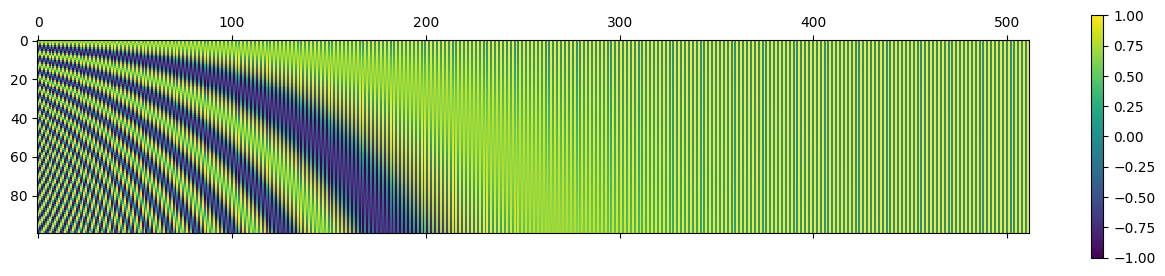

In [8]:
y = PositionalEncoder(512, 0.1, 100)
import numpy as np
import matplotlib.pyplot as plt
z = y.pe.squeeze(0)
cax = plt.matshow(z)
plt.gcf().colorbar(cax)

- **nn.Dropout演示**

In [9]:
m = nn.Dropout(p=0.2)
input = torch.randn(4, 5)
output = m(input)
print(output)
print(output.shape)

tensor([[ 1.7588, -0.3950,  2.0613,  1.2115,  0.7516],
        [-0.1322,  1.6485, -0.0261, -0.3965, -1.3906],
        [ 0.0000,  0.0000,  0.0000,  1.8678,  2.4471],
        [-0.4930, -0.1966,  0.7018, -1.8139,  0.2880]])
torch.Size([4, 5])


- **torch.unsqueeze演示**

In [10]:
x=torch.tensor([1,2,3,4])
torch.unsqueeze(x,0)

tensor([[1, 2, 3, 4]])

In [11]:
torch.unsqueeze(x,1)

tensor([[1],
        [2],
        [3],
        [4]])

- **实例化参数**

In [12]:
# 词嵌入维度是512维
d_model = 512
 
# 置0比率为0.1
dropout = 0.1
 
# 句子最大长度
max_len=60

- **输入参数**

In [13]:
# 输入x是Embedding层的输出的张量, 形状是2 x 4 x 512
x = embr
x

tensor([[[-32.7393,   3.0649,   8.7108,  ..., -42.1194,   2.4426,  31.8148],
         [ 32.3184,  24.1450,  10.9417,  ...,  25.7377,   1.0313,  13.9621],
         [ 33.4031,  16.5290,  -9.3316,  ..., -34.3460,  23.5138,   6.6676],
         [ 15.7550,  11.7889,  12.4468,  ..., -18.2665,  33.4889,  14.4125]],

        [[ -8.5730,  36.1309,  16.1838,  ...,  -7.4920, -41.7363,  11.3053],
         [-29.8006, -25.2407,   0.0933,  ...,  32.6949,   7.4500,  47.7094],
         [  2.1305,  -5.5537,  25.1537,  ...,   4.7739,  16.0176,  15.3828],
         [-22.1473, -18.1297, -20.8395,  ...,   3.5713, -24.7577, -21.1084]]],
       grad_fn=<MulBackward0>)

- **调用与输出效果**

In [14]:
pe = PositionalEncoder(d_model, dropout, max_len)
pe_result = pe(x)
print("pe_result:", pe_result)
print(pe_result.shape)

pe_result: tensor([[[-36.3770,   4.5166,   0.0000,  ..., -45.6883,   2.7140,  36.4609],
         [ 36.8443,  27.4281,  13.0706,  ...,  29.7086,   1.1460,  16.6245],
         [ 38.1249,  17.9032,  -9.3280,  ..., -37.0511,   0.0000,   8.5195],
         [ 17.6624,  11.9988,  14.1021,  ...,  -0.0000,  37.2103,  17.1250]],

        [[ -9.5256,  41.2566,  17.9820,  ...,  -7.2134, -46.3737,  13.6726],
         [-32.1768, -27.4449,   1.0168,  ...,  37.4388,   8.2779,  54.1216],
         [  3.3776,  -6.6332,  28.9891,  ...,   6.4154,  17.7975,  18.2031],
         [-24.4514, -21.2441, -22.8827,  ...,   5.0792, -27.5082, -22.3427]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


- **绘制词汇向量中特征的分布曲线**

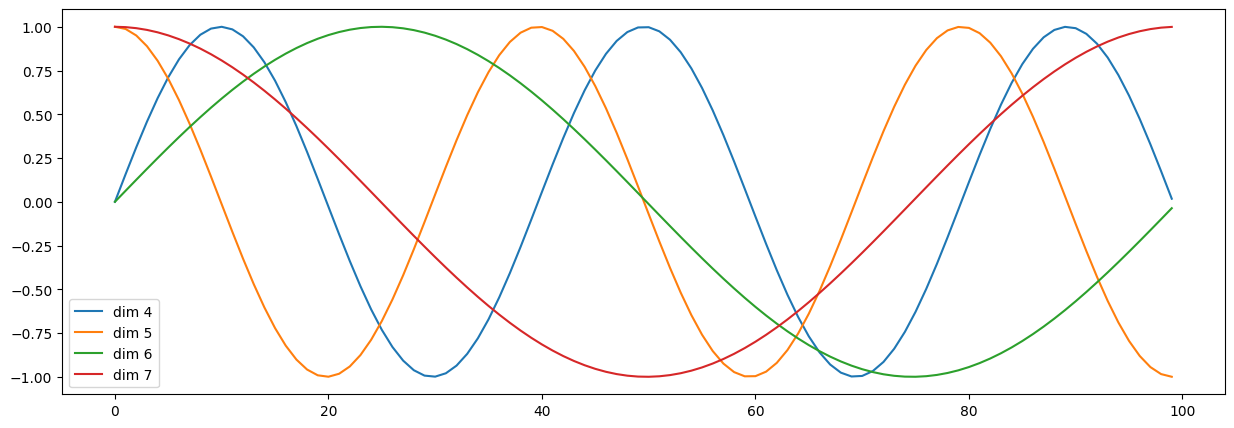

In [15]:
import matplotlib.pyplot as plt
import numpy as np
 
# 创建一张15 x 5大小的画布
plt.figure(figsize=(15, 5))
 
# 实例化PositionalEncoding类得到pe对象, 输入参数是20和0
pe = PositionalEncoder(20, 0)
 
# 然后向pe传入被Variable封装的tensor, 这样pe会直接执行forward函数, 
# 且这个tensor里的数值都是0, 被处理后相当于位置编码张量
y = pe(Variable(torch.zeros(1, 100, 20)))
 
# 然后定义画布的横纵坐标, 横坐标到100的长度, 纵坐标是某一个词汇中的某维特征在不同长度下对应的值
# 因为总共有20维之多, 我们这里只查看4，5，6，7维的值.
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
 
# 在画布上填写维度提示信息
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 三、掩码张量
- **什么是掩码张量**
 
掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有1和0的元素，代表位置被遮掩或者不被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩，也可以说被替换, 它的表现形式是一个张量.
- **掩码张量的作用**
 
在`transformer`中, 掩码张量的主要作用在应用`attention`(将在下一小节讲解)时，有一些生成的`attention`张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行`Embedding`，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用. 所以，我们会进行遮掩. 
- **生成掩码张量的代码分析**

In [16]:
def subsequent_mask(size):
    """
    生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它的最后两维形成一个方阵
    """
    # 在函数中，首先定义掩码张量的形状
    attn_shape = (1, size, size)
    # 然后使用np.ones方法向这个形状中添加1元素，形成上三角，最后为节约空间
    # 在使其中的数据类型变为无符号8位整形uint8
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 最后将"numpy"类型转化为torch中的"tensor"，内部一个"1 - "操作
    # 在这个其实是做了一个三角阵的反转，subsequent_mask中的每一元素都会被1减
    # 如果是0，subsequent_mask中的该位置由0变成1
    # 如果是1，subsequent_mask中的该位置由1变成0
    return torch.from_numpy(1-subsequent_mask)

- **np.triu演示**

In [17]:
import numpy as np
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=-1)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 0,  8,  9],
       [ 0,  0, 12]])

In [18]:
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=0)

array([[1, 2, 3],
       [0, 5, 6],
       [0, 0, 9],
       [0, 0, 0]])

In [19]:
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=1)

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0],
       [0, 0, 0]])

- **输入实例**

In [20]:
# 生成的掩码张量的最后两维的大小
size = 5

- **调用**

In [21]:
sm = subsequent_mask(size)
print("sm:",sm)

sm: tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


- **掩码张量的可视化**

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

- **效果分析**
    - 通过观察可视化方阵，黄色是1的部分，这里代表被遮掩，紫色代表没有被遮掩的信息，横坐标代表目标词汇的位置，纵坐标代表可查看的位置
    - 我们看到，在0的位置我们一看望过去都是黄色的，都被遮住了，1的位置一阎王过去汉是黄色，说明第一次词还没有产生，从第二个位置看过去，就能看到位置1的次，其他位置看不到，以此类推

## 四、注意力机制
- **什么是注意力**
    - 我们观察事物时，之所以能够快速判断一种事物(当然允许判断是错误的)，是因为我们大脑能够快速的把注意力放在事物最具有辨识度的部分从而作出判断，而非是从头到尾的观察一遍事物，才能有判断结果。正是基于这样的理论，就产生了注意力机制
- **什么是注意力计算规则**
    - 他需要三个指定的输入`Q(query)`,`K(key)`,`V(value)`，然后通过公式得到注意力的计算结果，这个结果代表`query`在`key`和`value`的作用下的表示。而这个具体计算规则有很多种，以下介绍用到的一种
$$
\text{Attention}\left(Q,K,Y\right)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
    - Q,K,V的比喻解释
> 假如我们有一个问题: 给出一段文本，使用一些关键词对它进行描述!
> 为了方便统一正确答案，这道题可能预先已经给大家写出了一些关键词作为提示.其中这些给出的提示就可以看作是key， 
而整个的文本信息就相当于是query，value的含义则更抽象，可以比作是你看到这段文本信息后，脑子里浮现的答案信息，
这里我们又假设大家最开始都不是很聪明，第一次看到这段文本后脑子里基本上浮现的信息就只有提示这些信息，
因此key与value基本是相同的，但是随着我们对这个问题的深入理解，通过我们的思考脑子里想起来的东西原来越多，
并且能够开始对我们query也就是这段文本，提取关键信息进行表示.  这就是注意力作用的过程， 通过这个过程，
我们最终脑子里的value发生了变化，
根据提示key生成了query的关键词表示方法，也就是另外一种特征表示方法.
>
> 刚刚我们说到key和value一般情况下默认是相同，与query是不同的，这种是我们一般的注意力输入形式，
> 但有一种特殊情况，就是我们query与key和value相同，这种情况我们称为自注意力机制，就如同我们的刚刚的例子， 
> 使用一般注意力机制，是使用不同于给定文本的关键词表示它. 而自注意力机制,
> 需要用给定文本自身来表达自己，也就是说你需要从给定文本中抽取关键词来表述它, 相当于对文本自身的一次特征提取.


- **什么是注意力机制**

    - 注意力机制是注意力计算规则能够应用的深度学习网络的载体，除了注意力计算规则之外，还包括一些必要的`全连接层`以及相关张量处理，使其与应用网络融为一体，使用自注意力计算规则的注意力机制称为自注意力机制
     
- **缩放点积注意力机制在网络中实现的图形表示**

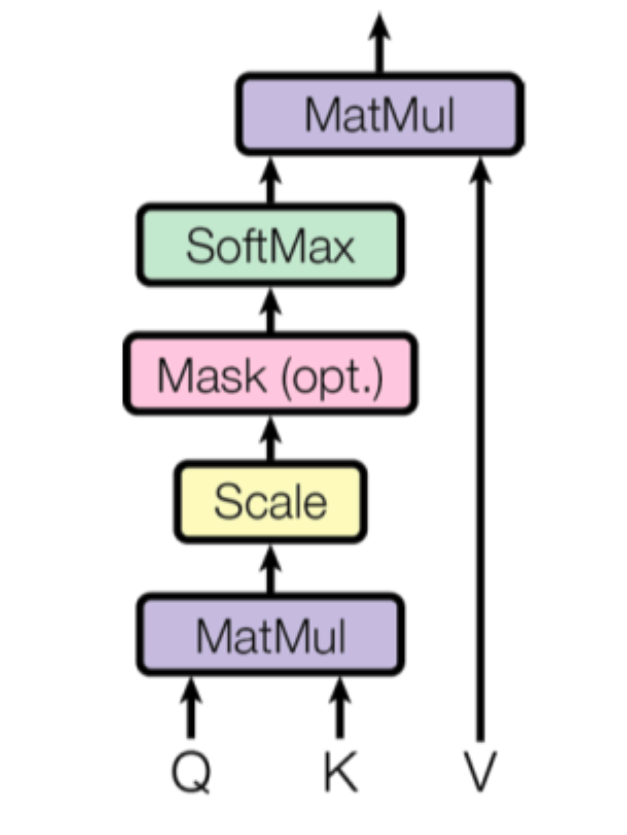

- **注意力计算规则的代码分析**

In [29]:
def attention(query, key, value, mask=None, dropout=None):
    """
    注意力机制的实现，输入分别是query, key, value, mask:掩码张量，dropout是nn.Dropout层的实例化对象，默认为None
    """
    # 在函数中，首先取query的最后一维的大小，一般情况下就等同于我们的词嵌入维度，命名为d_k
    d_k = query.size(-1)
    # 按照注意力公式，将query和key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数d_k^{1/2}，这种计算方法也称为缩放点积注意力计算
    # 得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    # 接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的mask_fill方法，将掩码张量和scores张量每一个位置一一比较，如果掩码张量处为0，则对应的scores张量用-1e9这个值来替换, 如下演示
        scores = scores.masked_fill(mask==0,-1e9)
    # 对scores的最后一维进行softmax操作，使用F.softmax方法，第一个参数是softmaxk对象，第二个是目标维度，这样获得最终的注意力张量
    p_attn = F.softmax(scores, dim=-1)
    # 之后判断是否使用dropout进行随机置0
    if dropout is not None:
        # 将p_attn传如dropout对象中进行'丢弃'处理
        p_attn = dropout(p_attn)
    # 最后，根据公式，将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

- **tensor.masked_fill演示**

In [31]:
input = Variable(torch.randn(5,5))
input

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [32]:
mask = Variable(torch.zeros(5,5))
mask

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [33]:
input.masked_fill(mask==0, -1e9)

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

- **输入参数**

In [35]:
# 我们令输入的query，key，value都相同，位置编码的输出
query=key=value=pe_result
query

tensor([[[-36.3770,   4.5166,   0.0000,  ..., -45.6883,   2.7140,  36.4609],
         [ 36.8443,  27.4281,  13.0706,  ...,  29.7086,   1.1460,  16.6245],
         [ 38.1249,  17.9032,  -9.3280,  ..., -37.0511,   0.0000,   8.5195],
         [ 17.6624,  11.9988,  14.1021,  ...,  -0.0000,  37.2103,  17.1250]],

        [[ -9.5256,  41.2566,  17.9820,  ...,  -7.2134, -46.3737,  13.6726],
         [-32.1768, -27.4449,   1.0168,  ...,  37.4388,   8.2779,  54.1216],
         [  3.3776,  -6.6332,  28.9891,  ...,   6.4154,  17.7975,  18.2031],
         [-24.4514, -21.2441, -22.8827,  ...,   5.0792, -27.5082, -22.3427]]],
       grad_fn=<MulBackward0>)

- **调用**

In [36]:
attn, p_attn = attention(query, key, value)
print("attn:", attn)
print("p_attn:", p_attn)

attn: tensor([[[-36.3770,   4.5166,   0.0000,  ..., -45.6883,   2.7140,  36.4609],
         [ 36.8443,  27.4281,  13.0706,  ...,  29.7086,   1.1460,  16.6245],
         [ 38.1249,  17.9032,  -9.3280,  ..., -37.0511,   0.0000,   8.5195],
         [ 17.6624,  11.9988,  14.1021,  ...,   0.0000,  37.2103,  17.1250]],

        [[ -9.5256,  41.2566,  17.9820,  ...,  -7.2134, -46.3737,  13.6726],
         [-32.1768, -27.4449,   1.0168,  ...,  37.4388,   8.2779,  54.1216],
         [  3.3776,  -6.6332,  28.9891,  ...,   6.4154,  17.7975,  18.2031],
         [-24.4514, -21.2441, -22.8827,  ...,   5.0792, -27.5082, -22.3427]]],
       grad_fn=<UnsafeViewBackward0>)
p_attn: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


- **带有mask的输入参数**

In [41]:
query=key=value=pe_result
print(query.shape)
# 令mask为一个2*4*8的零张量
mask=Variable(torch.zeros(2,4,4))
attn,p_attn = attention(query, key, value, mask=mask)
print("attn:",attn)
print("p_attn:",p_attn)

torch.Size([2, 4, 512])
attn: tensor([[[ 14.0636,  15.4617,   4.4612,  ..., -13.2577,  10.2676,  19.6825],
         [ 14.0636,  15.4617,   4.4612,  ..., -13.2577,  10.2676,  19.6825],
         [ 14.0636,  15.4617,   4.4612,  ..., -13.2577,  10.2676,  19.6825],
         [ 14.0636,  15.4617,   4.4612,  ..., -13.2577,  10.2676,  19.6825]],

        [[-15.6941,  -3.5164,   6.2763,  ...,  10.4300, -11.9516,  15.9136],
         [-15.6941,  -3.5164,   6.2763,  ...,  10.4300, -11.9516,  15.9136],
         [-15.6941,  -3.5164,   6.2763,  ...,  10.4300, -11.9516,  15.9136],
         [-15.6941,  -3.5164,   6.2763,  ...,  10.4300, -11.9516,  15.9136]]],
       grad_fn=<UnsafeViewBackward0>)
p_attn: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
 

## 五、多头注意力机制
- **什么是多头注意力机制**

    多头注意力机制（Multi-Head Attention）是[Transformer模型](https://so.csdn.net/so/search?q=Transformer%E6%A8%A1%E5%9E%8B&spm=1001.2101.3001.7020)中的一个关键组件，用于处理序列数据，特别是在自然语言处理任务中。它的主要思想是将输入的查询（Query）、键（Key）和值（Value）通过多个独立的注意力头（Attention Heads）进行处理，然后将这些头的输出拼接起来并通过一个线性层进行整合。这种机制可以捕捉序列中不同位置的多种复杂关系。
- **多头注意力机制结构图**

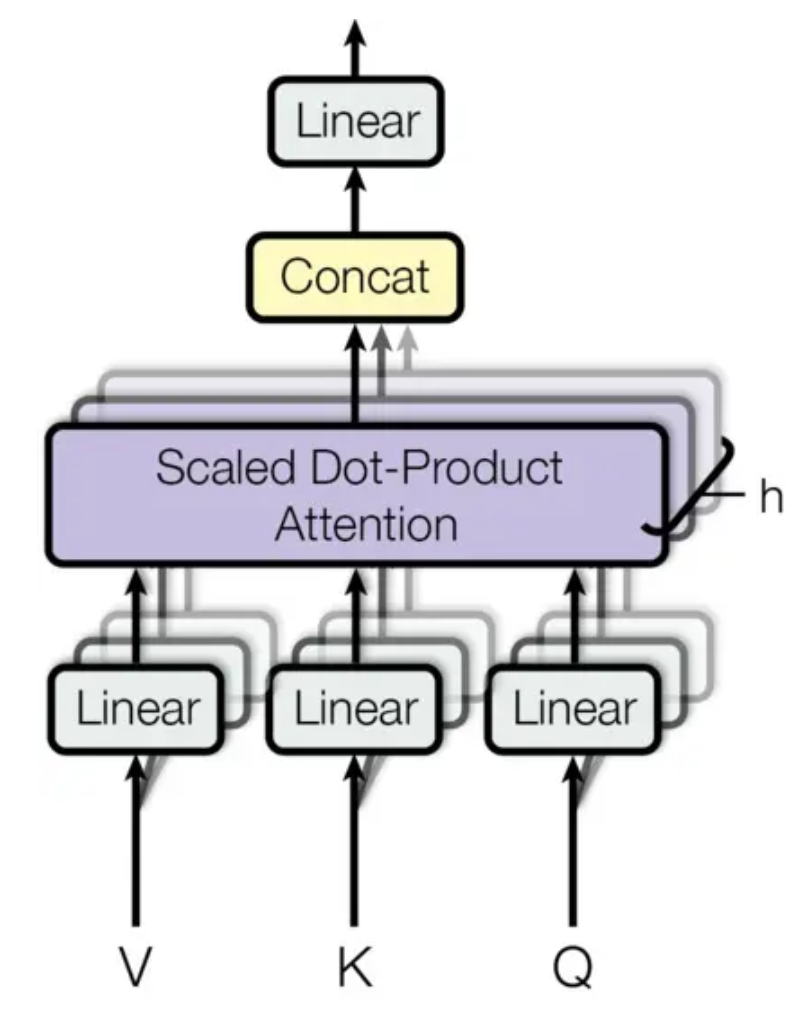

- **多头注意力机制的作用**

    这种结构设计能让每一个注意力机制区优化但个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果

- **以下是对多头注意力机制的详细解释**

In [48]:
# 用于深度拷贝的copy工具包
import copy
# 首先需要定义克隆函数，因为在多头注意力机制的实现中，用到多个结构相同的线性层
# 我们将使用clone函数将他们一同初始化在一个网络层列表对象中，之后的结构中也会用到该函数
def clones(module, N):
    """用于生成相同网络层的克隆函数，它的参数module表示要克隆的目标网络层，N代表需要克隆的数量"""
    # 在函数中，我们通过for循环对module进行N次深度拷贝，使其每个module成为独立的层
    # 然后将其放在nn.ModuleList类模型的列表中存放
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 我们使用一个类来实现多头注意力机制的处理
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embeding_dim, dropout=0.1):
        """在类的初始化时，会传入三个参数，head代表头数，embedding_dim代表词嵌入的维度，dropout代表进行dropout操作时置0比率，默认是0.1"""
        super(MultiHeadedAttention, self).__init__()
        # 在函数中，首先使用了一个测试中常用assert语句，判断h是否能被d_model整除
        # 这是因为我们之后要给每个头分配等两的词特征，也就是embedding_dim//head个
        assert embeddin_dim % head == 0
        # 得到每个头获得的分隔词向量维度d_k
        self.d_k = embedding_dim // head
        # 传入头数h
        self.head = head
        # 然后获得线性层对象，通过nn的Linear实例化，它的内部变换矩阵是embeding_dim*embedding_dim,然后使用clones函数克隆4个
        # 为什么是四个呢，这是因为在多头注意力中，Q，K，V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个.
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        # self.attn为None,它代表最后得到的注意力张量，现在还没有结果所以为None
        self.attn = None
        # 最后就是一个self.dropout对象，它通过nn中的Dropout实例化而来，置0比率为传进来的参数dropout
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """如果存在掩码张量mask"""
        if mask is not None:
            # 使用unsqueeze扩展维度
            mask = mask.unsqueeze(0)
        # 接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本，
        batch_size = query.size(0)
        # 进入多头处理环节
        # 1. 利用zip将输入q,k,v与三个线性层组到一起，然后使用for循环，将输入q,k,v分别传到线性层中
        # 2. 做完线性变换后，开始为每个头分割输入，这里使用iew方法对线变换的结果进行维度重建，多加了一个维度h，
        # 代表头数，这就意味着每一个头可以获得一部分词特征组成的句子，其中-1代表自适应维度，
        # 计算机会根据这种变换自动计算这里的值，然后对第二维和第三维进行转置操作
        # 3. 为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词一与句子的位置关系，
        # 从attention函数中可以看到，利用的是原始输入的倒数第一和第二维，这样我们就得到了每个头的输入
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2) 
                             for model, x in zip(self.linears, (query, key, value))]
        # 得到每个头的输入后，接下来就是将他们传入到attention中
        # 这里直接调用我们之前实现的attention函数。同时也将mask和dropout传入其中
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为诸如的形状一方便后续的计算
        # 因此这里开始第一部处理环节的逆操作，先对第二和第三维进行转置，然后使用contguous方法
        # 这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用
        # 所以，下一步u就是使用view重塑形状，变成和输入形状相同
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head*self.d_k)
        # 最后使用线性层列表中的最后一个线性层对输入进行线性变换得到最终的多头注意力结构输出
        return self.linears[-1](x)

- **tensor.view演示**

In [49]:
x = torch.randn(4,4)
x.size()

torch.Size([4, 4])

In [50]:
y = x.view(16)
y.size()

torch.Size([16])

In [53]:
z = x.view(-1, 8) # the size -1 is inferred from other dimensions
z.size()

torch.Size([2, 8])

In [54]:
a = torch.randn(1,2,3,4)
a.size()

torch.Size([1, 2, 3, 4])

In [56]:
b = a.transpose(1, 2) # swaps 2nd and 3rd dimension
b.size()

torch.Size([1, 3, 2, 4])

In [60]:
c = a.view(1,3,2,4) # Does not change tensor layout in memory
c.size()

torch.Size([1, 3, 2, 4])

In [61]:
torch.equal(b,c)

False

- **torch.transpose演示**

In [63]:
x = torch.randn(2,3)
x

tensor([[-0.9666, -0.0547,  1.6818],
        [ 0.3716,  2.0130,  0.3465]])

In [64]:
torch.transpose(x, 0, 1)

tensor([[-0.9666,  0.3716],
        [-0.0547,  2.0130],
        [ 1.6818,  0.3465]])

- **实例化参数与输入参数**

In [66]:
# 头数head
head = 8
# 词嵌入维度embedding_dim
embedding_dim = 512
# 置零比率dropout
dropout=0.2
# 假设输入的Q，K，V依然相等
query=value=key=pe_result
# 输入的掩码张量mask
mask = Variable(torch.zeros(8,4,4))

- **调用**

In [ ]:
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result =  mha(query, key, value, mask)
print(mha

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.q_linear = nn.linear(d_model, d_model)
        self.v_linear = nn.linear(d_model, d_model)
        self.k_linear = nn.linear(d_model, d_model)
        self.dropoutt = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask==0, -1e9)
        scores = F.softmask(scores)
        if dropout is not None:
            scores = dropout(scores)
        output = torch.matmul(scores, v)
        return output

    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k).transpose(1,2)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k).transpose(1,2)
        scores = self.attention(q, k, v, self.d_k, maks, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        return output
        

转置操作`transpose(1,2)`是为了在多头注意力计算中正确对齐每个头的`query`、`key`和`value`，指的是，矩阵计算在`sequence_length`,`d_k`这两个维度上进行

## 四、前馈神经网络(FeedForward)和层归一化(NormLayer)

**FeedForward模块**

FeedForward模块是一个简单的前馈神经网络，通常紧跟在多头注意力机制之后。它由两个线性层和一个激活函数组成，中间包含一个丢弃层(Dropout)以防止过拟合。

**代码解析**

In [23]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

- **初始化**
    - `d_model`: 输入和输出的维度
    - `d_ff`: 中间层的维度，默认值设置为2048
    - `dropout`：丢弃层，默认值设为0.1
    - `self.linear1`：第一个线性层，将输入从`d_model`维度映射到`d_ff`维度
    - `self.dropout`：丢弃层，用于防止过拟合
    - `self.linear2`：第二个线性层，将输入从`d_ff`维度映射回`d_model`维度
- **前向传播**
    - `self.linear1(x)`: 将输入`x`从`d_model`维度映射到`d_ff`维度
    - `F.relu(self.linear1(x))`: 应用`ReLU`激活函数
    - `self.dropout(F.relu(self.linear1(x)))`: 应用丢弃层
    - `self.linear2(x)`: 将输入从`d_ff`维度映射会`d_model`维度

**NormLayer模块**

NormLayer模块是一层归一化曾，用于对输入进行归一化处理。层归一化通过对每个样本的所有特征进行归一化，是的每个样本的特征具有相同的均值和方差。

层归一化(Layer Normalization)的公式如下：
$$
\text{Norm}\left(x\right)=\alpha \cdot \left(\frac{x-\mu}{\sigma+\epsilon}\right)+\beta
$$
**代码解析**

In [24]:
class NormLayer(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(),__init__()
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x-x.mean(dim=-1, keepdim=True))/(x.std(dim=-1,keepdim=True))+self.bias
        return norm

- **初始化**
    - `d_model`: 输入和输出的维度
    - `eps`: 一个很小的数，用于防止除0错误，默认设置为1e-6
    - `self.alpha`: 一个可学习的缩放参数，初始化为全1
    - `self.bias`：一个科学系的偏移参数，初始化为全0
- **前向传播**
    - `x.mean(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的均值
    - `x.std(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的标准差
    - `(x.mean(dim=-1,keepdim=True)) / (x.std(dim=-1,keepdim=True) + self.eps)`: 对输入`x`进行归一化处理
    - `x.std(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的标准差
    - `self.alpha * ... + self.bias`：应用可学习的缩放和偏移参数
这两个模块在Transformer模块中通常一起使用，FeedForward模块用于增加模型的非线性能力，而NormLayer模块用于稳定训练过程和加速收敛